<a href="https://colab.research.google.com/github/ab19493/Team48HousePreds/blob/master/HousepriceRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, boxcox_normmax
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, LassoLarsCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

#pd.set_option('display.float_format', lambda x: '%.3f' % x)
#%matplotlib inline

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
import pandas as pd
poo = 11

#google_csv = 'https://drive.google.com/open?id=1wLqmpUQrW1MeUkVqI6srbsHFDwJyHWfZ' #The sharable link

#fluff, id = google_csv.split('=')
#print (id) # Verify that you have everything after '='

#downloaded = drive.CreateFile({'id':id}) 
#downloaded.GetContentFile('train.csv')  
#downloaded.GetContentFile('test.csv')  
#house_prices = pd.read_csv('train.csv')
#test_data = pd.read_csv('test.csv')

from google.colab import files
uploaded = files.upload()
import io
house_prices = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test_data = pd.read_csv(io.BytesIO(uploaded['test.csv']))
sample_sub = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))

house_prices.sort_values(["SalePrice"], ascending=True) #Sorts stuff


Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,495,Unf,0,225,720,GasA,...,N,FuseA,720,0,0,720,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,523,115,0,0,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
916,917,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,3,1949,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,50,Unf,0,430,480,GasA,...,N,FuseA,480,0,0,480,1,0,0,0,1,1,TA,4,Typ,0,NaN,Detchd,1958.0,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml,35311
968,969,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,3,6,1910,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,600,600,Grav,...,N,SBrkr,600,368,0,968,0,0,1,0,2,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml,37900
533,534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,Inside,Mod,BrkSide,Norm,Norm,1Fam,1Story,1,3,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,Fa,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,...,N,FuseF,334,0,0,334,0,0,1,0,1,1,Fa,2,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,39300
30,31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,GasA,...,N,SBrkr,649,668,0,1317,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1734,1734,GasA,...,Y,SBrkr,1734,1088,0,2822,0,0,3,1,4,1,Ex,12,Typ,1,Gd,BuiltIn,2009.0,RFn,3,1020,TA,TA,Y,52,170,0,0,192,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188,Unf,0,142,2330,GasA,...,Y,SBrkr,2364,0,0,2364,1,0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3,820,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,...,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300

In [0]:
print(test_data)

        Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
0     1461          20       RH  ...    2010        WD        Normal
1     1462          20       RL  ...    2010        WD        Normal
2     1463          60       RL  ...    2010        WD        Normal
3     1464          60       RL  ...    2010        WD        Normal
4     1465         120       RL  ...    2010        WD        Normal
...    ...         ...      ...  ...     ...       ...           ...
1454  2915         160       RM  ...    2006        WD        Normal
1455  2916         160       RM  ...    2006        WD       Abnorml
1456  2917          20       RL  ...    2006        WD       Abnorml
1457  2918          85       RL  ...    2006        WD        Normal
1458  2919          60       RL  ...    2006        WD        Normal

[1459 rows x 80 columns]


In [0]:
#Statistics Summary
#Gives you the Average, Minimum and Maximum house prices among other useful data.
house_prices['SalePrice'].describe() 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [0]:
#Shows you all the column names/variables in the dataset.

house_prices.columns 

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

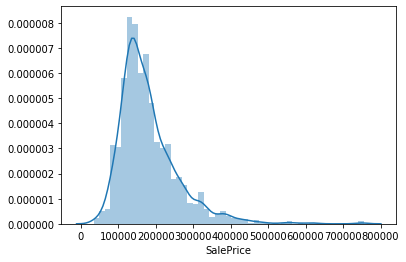

In [0]:
#Histogram
#The Majority of the homes salesprices are 180000 and steeply declines (large peak)
#The data is spread out evenly (positive skew)
#Deviates from the normal distribution.

sns.distplot(house_prices['SalePrice'])

In [0]:
#Skew and Kurtosis
print("Skewness: %f" % house_prices['SalePrice'].skew())
print("Kurtosis: %f" % house_prices['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


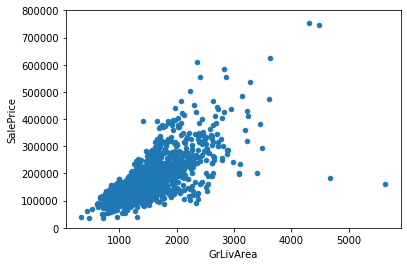

In [0]:
#Scattergraph
#Relationship between GrLivArea/Saleprice
#Linear relationship

var = 'GrLivArea'
data = pd.concat([house_prices['SalePrice'], house_prices[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

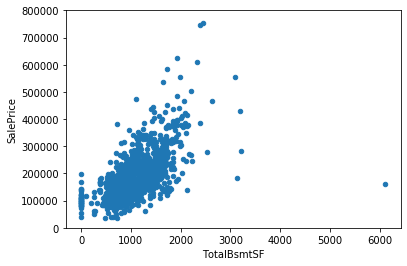

In [0]:
#Scattergraph
#Relationship between TotalBsmtSF/Saleprice
#Affects Saleprice most of the time
#Sometimes doesnt affect it and saleprice is independent from TotalBsmtSF (Strong Linear reaction)

var = 'TotalBsmtSF'
data = pd.concat([house_prices['SalePrice'], house_prices[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

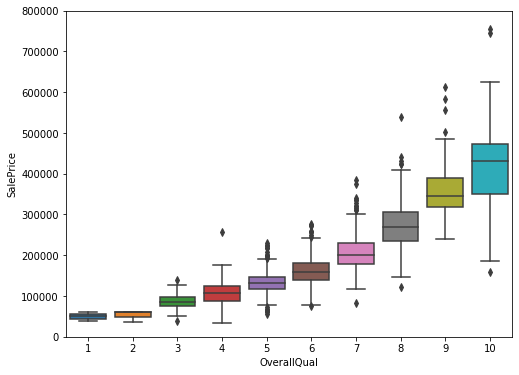

In [0]:
#Box plots are better suited for 'categorical' data
#OverallQuality/Salesprice
#This graph shows us that OverallQuality has a postive correaltion with the sales price.

var = 'OverallQual'
data = pd.concat([house_prices['SalePrice'], house_prices[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

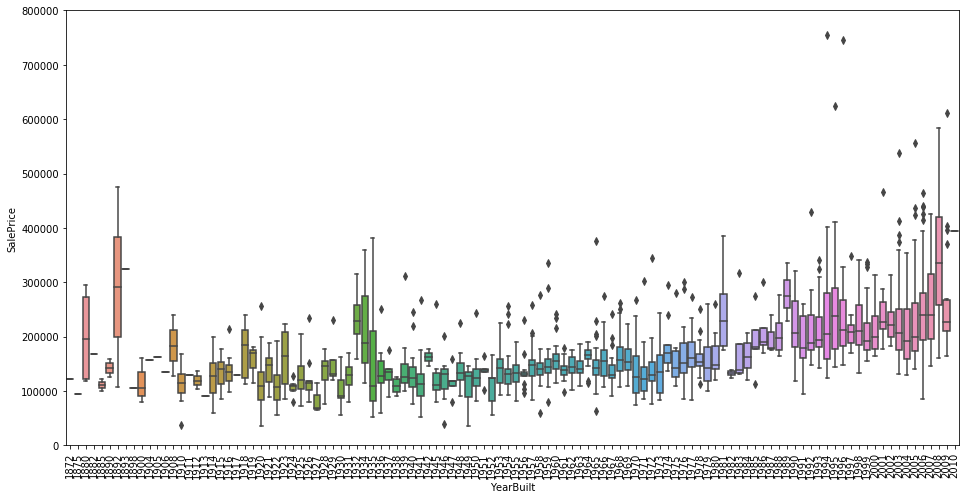

In [0]:
#Box plot
#Yearbuilt/Saleprice
#Sales price is generally higher for newer homes however that is not always the case

var = 'YearBuilt'
data = pd.concat([house_prices['SalePrice'], house_prices[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

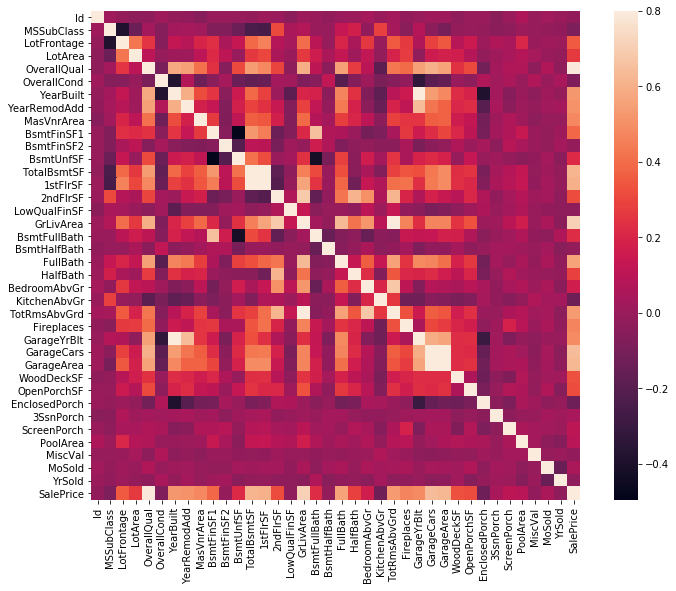

In [0]:
#Correlation Matrix (Heat map)
#Useful tool to see correlations at a glance
#Points of interest: TotalBsmtSF, 1stFlrSF, GarageCars, GarageArea (Multicollinearity/Very Strong Correlation)

corrmat = house_prices.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, xticklabels=True, yticklabels=True, square=True);

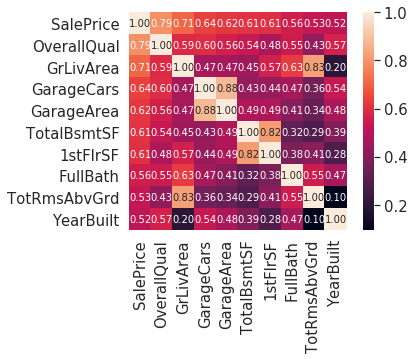

In [0]:
#Saleprice Correlation Matrix 
#Confirm that OverallQual. GrLivArea and TotalBsmtSF are strongly correlated with Saleprice
#GarageCars and GarageArea are strongly correlated with eachother however you only need to use one variable in the analysis as they're dependent on eachother.
#TotalBsmtSF and 1stFloor are strongly correlated with eachother.
#TotRmsAbvGrd and GrLivArea are also strongly correalted with eachother.
#Yearbuilt = Time-series analysis for more accuracy. !!!

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house_prices[cols].values.T)
sns.set(font_scale=1.35)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()



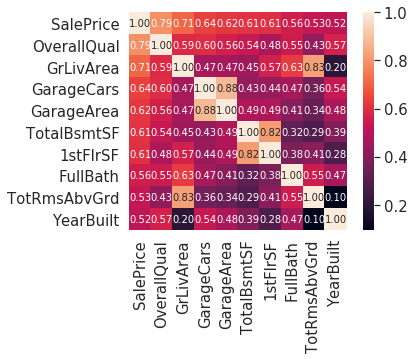

In [0]:
#Saleprice Correlation Matrix 
#Confirm that OverallQual. GrLivArea and TotalBsmtSF are strongly correlated with Saleprice
#GarageCars and GarageArea are strongly correlated with eachother however you only need to use one variable in the analysis as they're dependent on eachother.
#TotalBsmtSF and 1stFloor are strongly correlated with eachother.
#TotRmsAbvGrd and GrLivArea are also strongly correalted with eachother.
#Yearbuilt = Time-series analysis for more accuracy. !!!

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house_prices[cols].values.T)
sns.set(font_scale=1.35)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


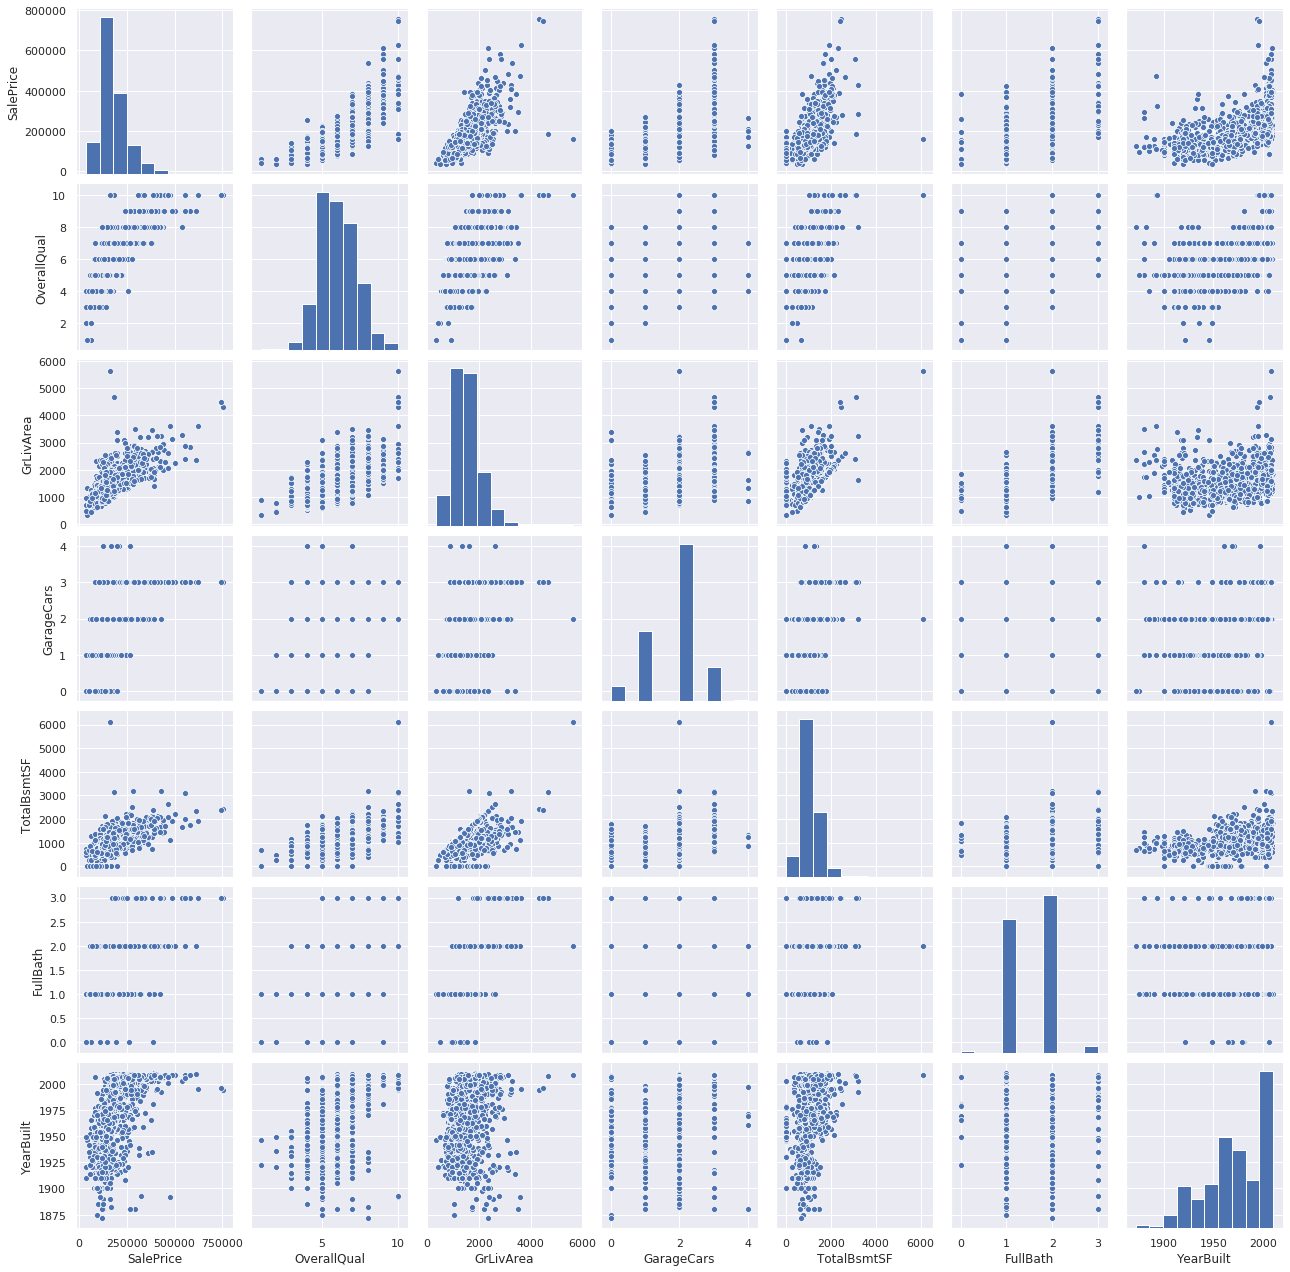

In [0]:
#Scatterplots between Saleprice and identifted correlated variables 
#Point of interest: TotalBsmtSF and GrLiveArea
#Linear line (Basement can be equal to the Living area but unusual if they're bigger)
#Point of interest: SalePrice and Yearbuil
#Saleprice tends to increase if the house is newer.
#There are examples that deviate from the trend. (why?)

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house_prices[cols], size = 2.5)
plt.show();

In [0]:
#Missing Data
#How prevalent is the missing data?
#Is it random or does it have a pattern?
#When 15% of the data is missing we should delete the corresponding variable

total = house_prices.isnull().sum().sort_values(ascending=False)
percent = (house_prices.isnull().sum()/house_prices.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [0]:
try:
  #Dealing with missing data

  house_prices = house_prices.drop((missing_data[missing_data['Total'] > 1]).index,1)
  house_prices = house_prices.drop(house_prices.loc[house_prices['Electrical'].isnull()].index)
  house_prices.isnull().sum().max() #just checking that there's no missing data missing...

  #Dealing with missing tests data 
  test_data= test_data.drop((missing_data[missing_data['Total'] > 1]).index,1)
  test_data= test_data.drop(test_data.loc[test_data['Electrical'].isnull()].index)

except:
  pass

In [0]:
#Out-liars. 
#Univariate Analysis 

#Standardizing data
#Converting data vlues to have a mean of 0 and a standard deviation of 1

saleprice_scaled = StandardScaler().fit_transform(house_prices['SalePrice'][:,np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

#Low range values are similar and not too far from 0
#High range values are far from 0 and the 7. values are really out of range
#Don't consider these values as outliers but be aware of the 7. values

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


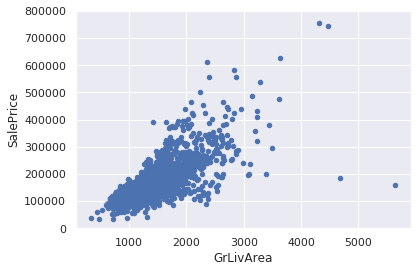

In [0]:
#Bivariate analysis

#Bivariate analysis Saleprice/GrlLivArea

var = 'GrLivArea'
data = pd.concat([house_prices['SalePrice'], house_prices[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

#Two values with very large GrLivArea. Not representative of typical case therefore outliers.
#The two at the top of the plot are the .7 observations. They seem to be following the trend.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


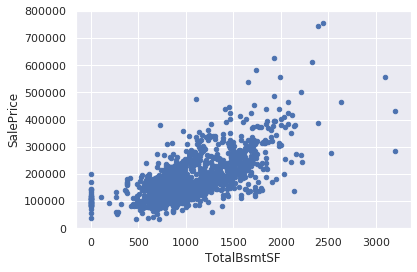

In [0]:
#Deleting points (The Large GrLivArea)

house_prices.sort_values(by = 'GrLivArea', ascending = False)[:2]
house_prices = house_prices.drop(house_prices[house_prices['Id'] == 1299].index)
house_prices = house_prices.drop(house_prices[house_prices['Id'] == 524].index)

#Bivariate analysis Saleprice/GrLivArea (New Analysis after deleted points.)

var = 'TotalBsmtSF'
data = pd.concat([house_prices['SalePrice'], house_prices[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));



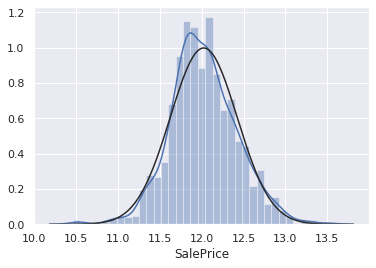

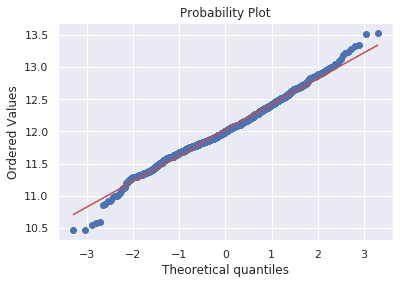

In [0]:
#How does SalePrice comply with the statistical assumptions we have made previously?
#Four assumptions should be tested
#Normality, Homoscedasticity, Linearity, Absence of correlated errors.

#Histogram and Normal Probability plot
#sns.distplot(house_prices['SalePrice'], fit=norm);
#fig = plt.figure()
#res = stats.probplot(house_prices['SalePrice'], plot=plt)

#SalePrice is not normal. Shows 'peakedness' and positive skewness
#It also does not follow the diagonal line.
#We can solve this problem using data transformation. Postivie skewness = log transformations

#Applying log transformation
house_prices['SalePrice'] = np.log(house_prices['SalePrice'])

#Transformed histogram and normal probability plot
sns.distplot(house_prices['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_prices['SalePrice'], plot=plt)

#Done. What can we gather?

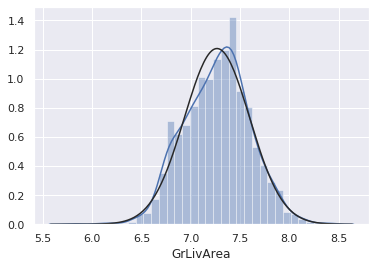

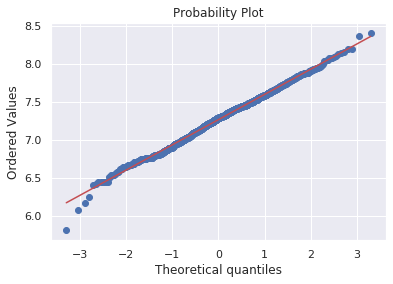

In [0]:
#Histogram and Normal Probability plot
#sns.distplot(house_prices['GrLivArea'], fit=norm);
#fig = plt.figure()
#res = stats.probplot(house_prices['GrLivArea'], plot=plt)

#Comes out very skewed, doesnt follow the line = Log transformation

#Data transformation
house_prices['GrLivArea'] = np.log(house_prices['GrLivArea'])
#Transformed histogram and normal probability plot
sns.distplot(house_prices['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_prices['GrLivArea'], plot=plt)

#Done. What can we gather?



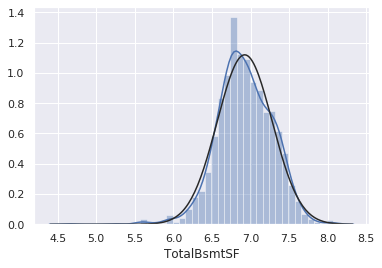

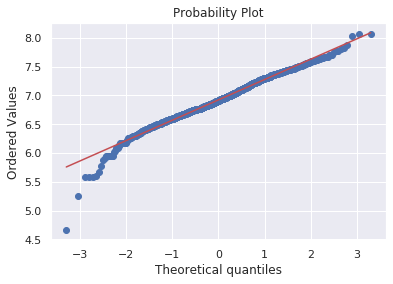

In [0]:
#Histogram and Normal Probability plot

#sns.distplot(house_prices['TotalBsmtSF'], fit=norm);
#fig = plt.figure()
#res = stats.probplot(house_prices['TotalBsmtSF'], plot=plt)

#Skewed
#Significant amount of value 0's
#0 values doesnt allow Log Transformation to work!

#To apply a log transformation we'll create a variable
#This variable will have the effect of having or not having basement (binary variable.)
#Then we can do a log transformation to all non-zero observations, ignoring value 0's

#Create column for new Variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
house_prices['HasBsmt'] = pd.Series(len(house_prices['TotalBsmtSF']), index=house_prices.index)
house_prices['HasBsmt'] = 0 
house_prices.loc[house_prices['TotalBsmtSF']>0,'HasBsmt'] = 1

#Transform data
house_prices.loc[house_prices['HasBsmt']==1,'TotalBsmtSF'] = np.log(house_prices['TotalBsmtSF'])

#Histogram and Normal Probability plot
sns.distplot(house_prices[house_prices['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(house_prices[house_prices['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

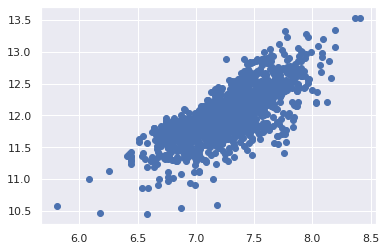

In [0]:
#Homoscedasticity
#Departures from an equal dispersion are shown by such shapes as cones
#Small dispersion at one side, large dispersion at the opposite ^
#Or Diamonds...
#A large number of points at the center of the distrubtion

#Scatter plot
#SalePrice/GrLivArea
plt.scatter(house_prices['GrLivArea'], house_prices['SalePrice']);

#No longer cone shaped like previous scatter graphs. 
#As long as the other variables have normality there is no problem with homoscedasticity.


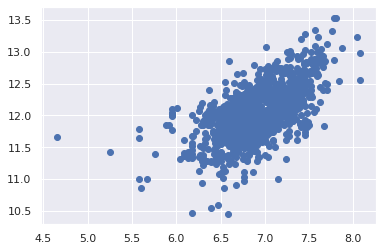

In [0]:
#Scatter plot
#SalePrice/TotalBsmtSF
plt.scatter(house_prices[house_prices['TotalBsmtSF']>0]['TotalBsmtSF'], house_prices[house_prices['TotalBsmtSF']>0]['SalePrice']);

#In general SalePrice exhibits equal levels of variance across the range of TotalBsmtSF.


In [0]:
#Dummy Variables
#Convert categorical variable into dummy
house_prices = pd.get_dummies(house_prices)
test_data = pd.get_dummies(test_data)

In [0]:
#filling NA's with the mean of the column:
house_prices = house_prices.fillna(house_prices.mean())
test_data = test_data.fillna(test_data.mean())

In [0]:
test_data.loc['MSSubClass':'SaleCondition']

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,...,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial


In [0]:
all_data = pd.concat((house_prices.loc[:,'MSSubClass':'SaleCondition_Normal'],
                      test_data.loc[:,'MSSubClass':'SaleCondition_Normal']))

all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

all_data.shape

all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

In [0]:
#X_train = house_prices[:house_prices.shape[0]]
X_train = all_data[:house_prices.shape[0]]
X_test = all_data[test_data.shape[0]:]
y = house_prices.SalePrice

In [0]:
X_test.shape

(1457, 220)

In [0]:
X_train.shape

(1457, 220)

In [0]:
data.shape

(1457, 2)

In [0]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [0]:
model_ridge = Ridge()

In [0]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

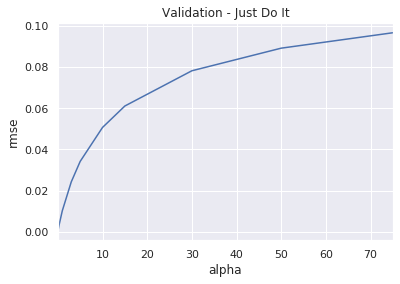

In [0]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [0]:
cv_ridge.min()

0.0006180243277326507

In [0]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [0]:
rmse_cv(model_lasso).mean()

0.0035386052279340685

In [0]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [0]:
model_ridge.fit(X_train, y)
X_test.shape

(1457, 220)

In [0]:
X_train.shape

(1457, 220)

In [0]:
ridge_preds = np.expm1(model_ridge.predict(X_test))
print(ridge_preds)

[1.25408662e+17 8.39641281e+16 6.59346421e+14 ... 2.46453794e+14
 2.75654922e+12 5.62131596e+19]


In [0]:
test_ID = test_data['Id'][0:1457]

solution = pd.DataFrame({"Id":X_test, "SalePrice":ridge_preds})
solution.to_csv("submit.csv", index = False)
files.download("submit.csv")

ValueError: ignored

In [0]:
print(test_ID)

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
Name: Id, Length: 1457, dtype: int64


In [0]:
house_prices.to_csv("traindata.csv")
X_test.to_csv("X_test.csv")

did_you_do_it = poo
